# Report

### Target is to identify which factors predict future user 'adoption'

#### Some Insights

1. We have 736 days of login data(105 weeks) in takehome_user_engagement.csv
2. Top 3 most visited users IDs 3623(606 times) ,906 (600times),1811(593 times)
3. ID 10742 invited most users.
4. Many users joined through ORG_INVITE(1) and Guest_invite(2) and less users joined through SIGNUP_GOOGLE_AUTH(1) and SIGNUP(2) less effective in grapping more users.[ code : df1.groupby('creation_source').count()['name'].sort_values() ]
5. Most user are active on 2014-05-30

#### SUMMARY

* created a column which tells whether an User is an adopted user(as 1) or not(as 0) [ code:users_log2.rolling(window=7, min_periods=1).sum() ]
* Merging two DFs using their similar column (User_id) to perform model Testing and training [ code: users_log3.merge(df1, how='inner', on='user_id', sort=True) ]
* changing the dtype(datetime) and adding active_days column to get additional insights
* counting the 2 classes 0 and 1 to know the difference between them,which reveals "the Proportion of class 0 is: 9.16 %".so the data was balanced using the SMOTETOMEK technique.
* Ploting the correlation between the features and Using Random Forest to evaluate the importance of features on the classification task.This reveals important features to predict whether an user is an 'adopted user': 0.invited_by_user_id 1.Number of active_days and 2.organization_id

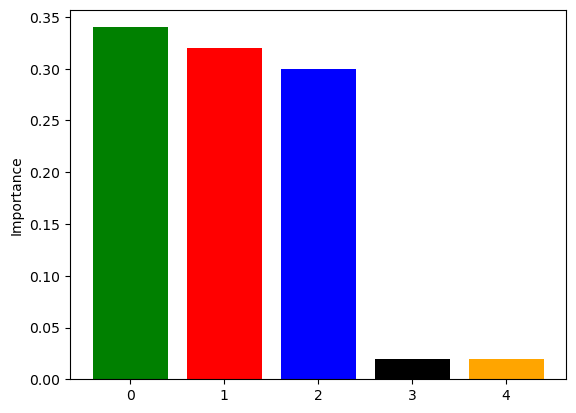

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek

### DF 'takehome_user_engagement.csv'

In [2]:
# to chek csv encoded type
with open('takehome_user_engagement.csv') as f:
    print(f)

<_io.TextIOWrapper name='takehome_user_engagement.csv' mode='r' encoding='cp1252'>


In [3]:
df1 = pd.read_csv('takehome_users.csv',encoding='cp1252') #<_io.TextIOWrapper name='takehome_users.csv' mode='r' encoding='cp1252'>
display(df1.head())
display(df1.info())

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


None

In [4]:
df1.rename(columns={'object_id':'user_id'}, inplace=True) #matching the column names of 2 df

In [5]:
df1.columns

Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')

### DF 'takehome_user_engagement.csv'

In [6]:
users_log = pd.read_csv('takehome_user_engagement.csv')
display(users_log.head())
display(users_log.info())

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


None

In [7]:
users_log.time_stamp=pd.to_datetime(users_log.time_stamp)
users_log2=users_log.set_index('time_stamp').groupby('user_id')['visited'].resample('D').count()

In [8]:
users_log2.head()

user_id  time_stamp
1        2014-04-22    1
2        2013-11-15    1
         2013-11-16    0
         2013-11-17    0
         2013-11-18    0
Name: visited, dtype: int64

In [9]:
users_log2=pd.DataFrame(users_log2)
users_log2.head()

visited
user_id time_stamp         
1       2014-04-22        1
2       2013-11-15        1
        2013-11-16        0
        2013-11-17        0
        2013-11-18        0

In [10]:
#Sum of the visits for seven rolling day periods.
users_log2 = users_log2.rolling(window=7, min_periods=1).sum()
users_log2.reset_index(inplace=True)
users_log2.head()

,user_id,time_stamp,visited
0,1,2014-04-22,1.0
1,2,2013-11-15,2.0
2,2,2013-11-16,2.0
3,2,2013-11-17,2.0
4,2,2013-11-18,2.0


In [11]:
#adding number of visits for each user for seven rolling day periods.
users_log3 = users_log2.groupby('user_id')[['visited']].max()
users_log3.head()

,visited
user_id,
1,1.0
2,3.0
3,2.0
4,3.0
5,4.0


In [12]:
# Adding New column 'adopted' in this coloum 1 represents True and 0 represents False
users_log3.loc[users_log3['visited'] >= 3, 'adopted_user'] = 1
users_log3.loc[users_log3['visited'] < 3, 'adopted_user'] = 0

In [13]:
# Changing the dtype to integer.
users_log3['visited'] = users_log3['visited'].astype(int)
users_log3['adopted_user'] = users_log3['adopted_user'].astype(int)
users_log3.reset_index(inplace=True) 
users_log3.head()

,user_id,visited,adopted_user
0,1,1,0
1,2,3,1
2,3,2,0
3,4,3,1
4,5,4,1


In [14]:
# Merging two data frames
df1 = users_log3.merge(df1, how='inner', on='user_id', sort=True)
df1.head()

,user_id,visited,adopted_user,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,3,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,3,1,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,4,1,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [15]:
df1.isnull().sum()

user_id                          0
visited                          0
adopted_user                     0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
dtype: int64

In [16]:
#The invited_by_user_id column's NaN values are filled with 0.
df1['invited_by_user_id'].fillna(0, inplace=True)
df1['invited_by_user_id'] = df1['invited_by_user_id'].astype(int)

In [17]:
#changing the dtype(datetime) and adding active_days column to get additional insights 
df1.last_session_creation_time = pd.to_datetime(df1.last_session_creation_time)
df1.creation_time = pd.to_datetime(df1.creation_time)
df1['active_days'] = df1['last_session_creation_time'] - df1['creation_time']
df1['active_days'] = df1['active_days'].dt.days
display(df1.tail())
display(df1.isnull().sum())

,user_id,visited,adopted_user,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days
8818,11996,4,1,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1970-01-01 00:00:01.378448055,0,0,89,8263,-15955
8819,11997,5,1,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1970-01-01 00:00:01.358274517,0,0,200,0,-15716
8820,11998,6,1,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1970-01-01 00:00:01.398602716,1,1,83,8074,-16188
8821,11999,7,1,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1970-01-01 00:00:01.338638159,0,0,6,0,-15492
8822,12000,7,1,2014-01-26 08:57:12,Lima Thaís,ThaisMeloLima@hotmail.com,SIGNUP,1970-01-01 00:00:01.390726632,0,1,0,0,-16097


user_id                       0
visited                       0
adopted_user                  0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
active_days                   0
dtype: int64

# ML

In [18]:
# Selecting columns for machine learning algorithms
df_ml = df1[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'active_days', 'adopted_user' ]]
df_ml.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days,adopted_user
0,GUEST_INVITE,1,0,11,10803,-16183,0
1,ORG_INVITE,0,0,1,316,-16025,1
2,ORG_INVITE,0,0,94,1525,-15784,0
3,GUEST_INVITE,0,0,1,5151,-15847,1
4,GUEST_INVITE,0,0,193,5240,-15723,1


The count of class 0 is: 808
The count of class 1 is: 8015
Proportion of class 0 is: 9.16 %


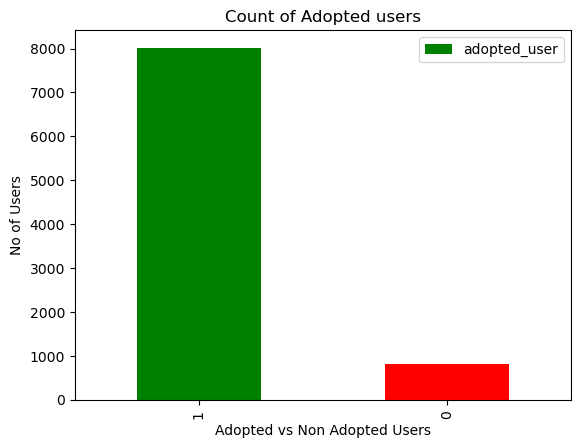

In [19]:
# counting the 2 classes 0 and 1 to know the difference between them
count=df_ml.adopted_user.value_counts()
print('The count of class 0 is:', count[0])
print('The count of class 1 is:', count[1])
print('Proportion of class 0 is:', round(count[0] * 100 / (count[1] +count[0]), 2),'%')

count.plot(kind='bar', title='Count of Adopted users',color=['green','red']);
plt.ylabel('No of Users')
plt.xlabel('Adopted vs Non Adopted Users')
plt.legend()
plt.show()

#### Training and Testing 

In [20]:
X=df_ml.iloc[:,1:-1]
y=df_ml.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=40)

In [21]:
# The data was balanced using the SMOTETOMEK technique.
smt = SMOTETomek(sampling_strategy='all')
X_balanced, y_balanced = smt.fit_resample(X_train, y_train)

In [22]:
display(y_train.value_counts())
display(y_balanced.value_counts())

1    5608
0     568
Name: adopted_user, dtype: int64

1    5093
0    5093
Name: adopted_user, dtype: int64

In [23]:
display(X_balanced.shape)
display(y_balanced.shape)

(10186, 5)

(10186,)

In [24]:
#Making dummy variables that we drop.
creation_source_dummy = pd.get_dummies(df_ml['creation_source'], drop_first=True)
creation_source_dummy.head()

,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,0,0,0,0
1,1,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,0,0,0


In [25]:
#concatinate the creation_source dummy with the X_balanced dataset to get all features.
X = pd.concat([X_balanced, creation_source_dummy], axis=1)
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,0,0,1,2546,-15870,0.0,0.0,0.0,0.0
1,0,0,55,6487,-15888,1.0,0.0,0.0,0.0
2,0,0,334,2765,-16106,1.0,0.0,0.0,0.0
3,0,0,0,11350,-15656,0.0,0.0,0.0,0.0
4,1,0,240,5261,-16210,0.0,0.0,0.0,0.0


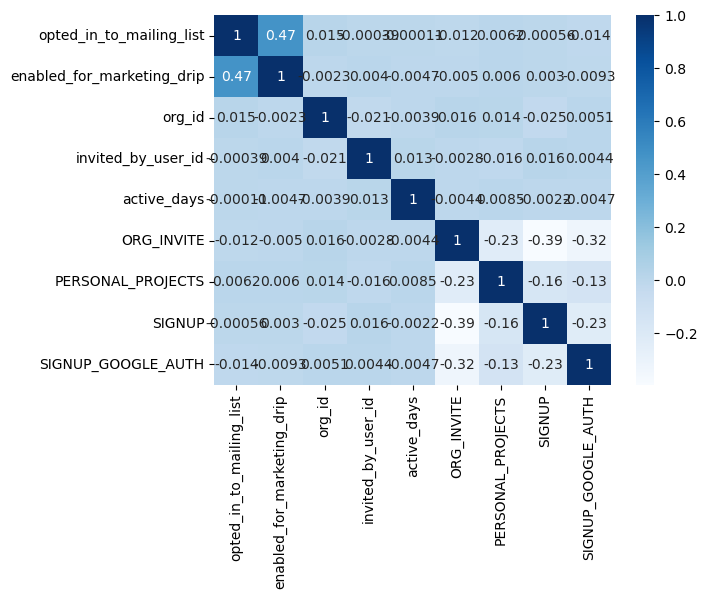

In [26]:
#Plot the correlation between the features
corr = X.corr()
sns.heatmap(corr,cmap="Blues",annot=True, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

In [27]:
# Using Random Forest to evaluate the importance of features on the classification task.
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
random_forest = RandomForestRegressor(n_estimators= 100, max_depth = 3, max_features='sqrt')
#Training the model. 
random_forest.fit(X_train,y_train)
y_predicted = random_forest.predict(X_test)

In [28]:
data_importance = list(random_forest.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(data_importance, 2)) for feature,data_importance in zip(X_balanced,data_importance)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: active_days          Importance: 0.34
Variable: org_id               Importance: 0.32
Variable: invited_by_user_id   Importance: 0.3
Variable: opted_in_to_mailing_list Importance: 0.02
Variable: enabled_for_marketing_drip Importance: 0.02


[None, None, None, None, None]

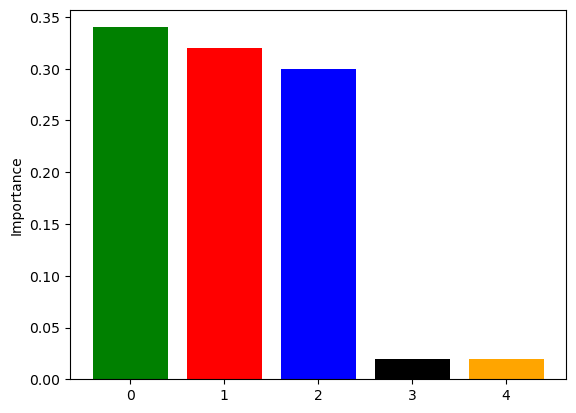

In [29]:
feature_importances.sort(key=lambda x: x[1], reverse=True)
feature_importances
feature = list(zip(*feature_importances))[0]
data_importance = list(zip(*feature_importances))[1]
x=np.arange(len(feature))
plt.bar(x,data_importance,color=['green','red','blue','black','orange'],align='center')
plt.xticks(x,x) 
plt.ylabel('Importance')
plt.show()